# Training Deep Neural Nets

![dnn-config](https://www.dropbox.com/s/77hfezzpek1n00y/default-dnn-config.png?dl=1)

This default configuration may need to be tweaked:
- If you can’t find a good learning rate (convergence was too slow, so you increased the training rate, and now convergence is fast but the network’s accuracy is suboptimal), then you can try adding a learning schedule such as exponential decay.
- If your training set is a bit too small, you can implement data augmentation. If you need a sparse model, you can add some ℓ1 regularization to the mix (and optionally zero out the tiny weights after training).
- If you need an even sparser model, you can try using FTRL instead of Adam optimization, along with ℓ1 regularization.
- If you need a lightning-fast model at runtime, you may want to drop Batch Normalization, and possibly replace the ELU activation function with the leaky ReLU. Having a sparse model will also help.

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Vanishing/Exploding Gradients Problem

Gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called the **vanishing gradients** problem.

In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the **exploding gradients** problem, which is mostly encountered in recurrent neural networks. More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

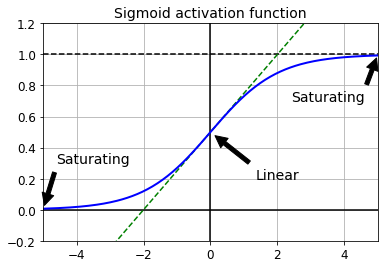

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show();

### Xavier and He Initialization

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name="hidden1")

### Nonsaturating Activation Functions

Unfortunately, the *ReLU* activation function is not perfect. It suffers from a problem known as the *dying ReLUs*: during training, some neurons effectively die, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. During training, if a neuron’s weights get updated such that the weighted sum of the neuron’s inputs is negative, it will start outputting 0. When this happens, the neuron is unlikely to come back to life since the gradient of the *ReLU* function is 0 when its input is negative.

**TIP**

So which activation function should you use for the hidden layers of your deep neural networks?

Although your mileage will vary, in general `ELU` > `leaky ReLU` (and its variants) > `ReLU` > `tanh` > `logistic`.

- If you care a lot about runtime performance, then you may prefer `leaky ReLUs` over `ELUs`.
- If you don’t want to tweak yet another hyperparameter, you may just use the default `α` values suggested earlier (0.01 for the `leaky ReLU`, and 1 for `ELU`).
- If you have spare time and computing power, you can use *cross-validation* to evaluate other activation functions, in particular `RReLU` if your network is overfitting, or `PReLU` if you have a huge training set.

#### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

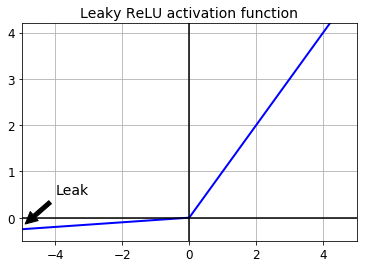

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show();

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [11]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [12]:
reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [13]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [14]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [15]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [16]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

In [17]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

In [19]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [20]:
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [21]:
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [22]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [23]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9654
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9764
25 Batch accuracy: 1.0 Validation accuracy: 0.9778
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


#### ELU

In [24]:
def elu(z, alpha=0.01):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

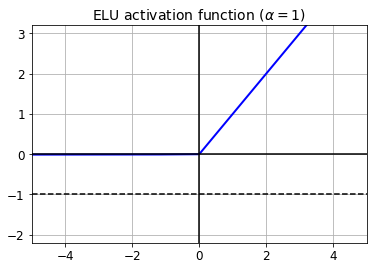

In [25]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show();

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [26]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [27]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

#### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I will definitely add it to the book). It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

In [28]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

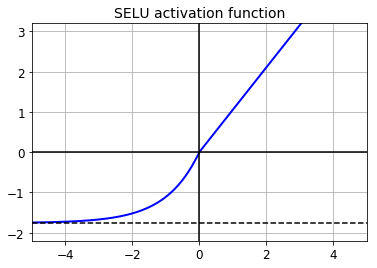

In [29]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show();

With this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [30]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))

for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


Here's a TensorFlow implementation (there will almost certainly be a `tf.nn.selu()` function in future TensorFlow versions):

In [31]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

SELUs can also be combined with dropout, check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz.

Let's create a neural net for MNIST using the SELU activation function:

In [32]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [33]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.923
5 Batch accuracy: 0.98 Validation accuracy: 0.9578
10 Batch accuracy: 1.0 Validation accuracy: 0.9664
15 Batch accuracy: 0.96 Validation accuracy: 0.9682
20 Batch accuracy: 1.0 Validation accuracy: 0.9694
25 Batch accuracy: 1.0 Validation accuracy: 0.9688
30 Batch accuracy: 1.0 Validation accuracy: 0.9694
35 Batch accuracy: 1.0 Validation accuracy: 0.97


## Batch Normalization

In a [2015 paper](https://arxiv.org/pdf/1502.03167v3.pdf), 7 Sergey Ioffe and Christian Szegedy proposed a technique called *Batch Normalization* (BN) to address the vanishing/exploding gradients problems, and more generally the problem that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change (which they call the *Internal Covariate Shift* problem).

The technique consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, the other for shifting). In other words, this operation lets the model learn the optimal scale and mean of the inputs for each layer.

In order to zero-center and normalize the inputs, the algorithm needs to estimate the inputs’ mean and standard deviation. It does so by evaluating the mean and standard deviation of the inputs over the current mini-batch (hence the name “Batch Normalization”).

![BN](https://www.dropbox.com/s/rmjoencidkkshu3/batch-normalization.png?dl=1)

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

In [34]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

In [35]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

In [36]:
from functools import partial

batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [37]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    
    batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=batch_norm_momentum)
    dense_layer = partial(tf.layers.dense, kernel_initializer=he_init)
    
    hidden1 = dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(batch_norm_layer(hidden1))
    hidden2 = dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(batch_norm_layer(hidden2))
    logits_before_bn = dense_layer(bn2, n_outputs, name="outputs")
    logits = batch_norm_layer(logits_before_bn)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [38]:
n_epochs = 20
batch_size = 200

In [39]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9042
1 Validation accuracy: 0.928
2 Validation accuracy: 0.9374
3 Validation accuracy: 0.9474
4 Validation accuracy: 0.9532
5 Validation accuracy: 0.9572
6 Validation accuracy: 0.9626
7 Validation accuracy: 0.9628
8 Validation accuracy: 0.9664
9 Validation accuracy: 0.968
10 Validation accuracy: 0.9694
11 Validation accuracy: 0.9696
12 Validation accuracy: 0.971
13 Validation accuracy: 0.971
14 Validation accuracy: 0.9728
15 Validation accuracy: 0.9734
16 Validation accuracy: 0.9728
17 Validation accuracy: 0.975
18 Validation accuracy: 0.9752
19 Validation accuracy: 0.976


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```


One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [40]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [41]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold. This is called *Gradient Clipping*. In general people now prefer *Batch Normalization*, but it’s still useful to know about *Gradient Clipping* and how to implement it.

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [42]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [43]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them:

In [44]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [45]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [46]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [47]:
n_epochs = 20
batch_size = 200

In [48]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7936
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9296
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9474
12 Validation accuracy: 0.9478
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9568
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9612


### Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network: this is called transfer learning. It will not only speed up training considerably, but will also require much less training data.

### Reusing a TensorFlow Model

If the original model was trained using TensorFlow, you can simply restore it and train it on the new task.

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [49]:
reset_graph()

In [50]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [51]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
eval/Const
eval/in_top_k/InTopKV2/k
GradientDescent/learning_rate
clip_by_value_11/clip_value_max
clip_by_value_11/clip_value_min
clip_by_value_10/clip_value_max
clip_by_value_10/clip_value_min
clip_by_value_9/clip_value_max
clip_by_value_9/clip_value_min
clip_by_value_8/clip_value_max
clip_by_value_8/clip_value_min
clip_by_value_7/clip_value_max
clip_by_value_7/clip_value_min
clip_by_value_6/clip_value_max
clip_by_value_6/clip_value_min
clip_by_value_5/clip_value_max
clip_by_value_5/clip_value_min
clip_by_value_4/clip_value_max
clip_by_value_4/clip_value_min
clip_by_value_3/clip_value_max
clip_by_value_3/clip_value_min
clip_by_value_2/clip_value_max
clip_by_value_2/clip_value_min
clip_by_value_1/clip_value_max
clip_by_value_1/clip_value_min
clip_by_value/clip_value_max
clip_by_value/clip_value_min
gradients/loss/SparseSoftmaxCrossEntropyWithLogits

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [52]:
# Works on Chrome, not guaranteed on other browsers

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [53]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [54]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [55]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important", op)

This way people who reuse your model will be able to simply write:

In [56]:
X, y, accuracy, training_op = tf.get_collection("my_important")

Now you can start a session, restore the model's state and continue training on your data:

In [57]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [58]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9636
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9658
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9646
5 Validation accuracy: 0.965
6 Validation accuracy: 0.969
7 Validation accuracy: 0.9682
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.971
12 Validation accuracy: 0.9668
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9726
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [59]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [60]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9646
5 Validation accuracy: 0.9652
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9708
19 Validation accuracy: 0.9712


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [61]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [62]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9246
1 Validation accuracy: 0.945
2 Validation accuracy: 0.953
3 Validation accuracy: 0.9582
4 Validation accuracy: 0.9606
5 Validation accuracy: 0.9562
6 Validation accuracy: 0.9622
7 Validation accuracy: 0.9624
8 Validation accuracy: 0.9642
9 Validation accuracy: 0.9644
10 Validation accuracy: 0.9656
11 Validation accuracy: 0.9664
12 Validation accuracy: 0.965
13 Validation accuracy: 0.9676
14 Validation accuracy: 0.9678
15 Validation accuracy: 0.9688
16 Validation accuracy: 0.9692
17 Validation accuracy: 0.97
18 Validation accuracy: 0.9688
19 Validation accuracy: 0.968


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [63]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [64]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # regex
restore_path = tf.train.Saver(reuse_vars) # restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_path.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):                                            
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     
        print(epoch, "Validation accuracy:", accuracy_val)                   

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9024
1 Validation accuracy: 0.9332
2 Validation accuracy: 0.943
3 Validation accuracy: 0.947
4 Validation accuracy: 0.9516
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9558
7 Validation accuracy: 0.9592
8 Validation accuracy: 0.9586
9 Validation accuracy: 0.9608
10 Validation accuracy: 0.9626
11 Validation accuracy: 0.962
12 Validation accuracy: 0.964
13 Validation accuracy: 0.9662
14 Validation accuracy: 0.966
15 Validation accuracy: 0.9662
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.9682
19 Validation accuracy: 0.9678


### Reusing Models from Other Frameworks

If the model was trained using another framework, you will need to load the model parameters manually (e.g., using Theano code if it was trained with Theano), then assign them to the appropriate variables. This can be quite tedious. For example, the following code shows how you would copy the weight and biases from the first hidden layer of a model trained using another framework.

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [65]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [66]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note: the weights variable created by the `tf.layers.dense()` function is called `"kernel"` (instead of `"weights"` when using the `tf.contrib.layers.fully_connected()`, as in the book), and the biases variable is called `bias` instead of `biases`.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [67]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [68]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [69]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [70]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

#### Freezing the Lower Layers

It is likely that the lower layers of the first DNN have learned to detect low-level features in pictures that will be useful across both image classification tasks, so you can just reuse these layers as they are. It is generally a good idea to “freeze” their weights when training the new DNN: if the lower-layer weights are fixed, then the higher-layer weights will be easier to train (because they won’t have to learn a moving target). To freeze the lower layers during training, one solution is to give the optimizer the list of variables to train, excluding the variables from the lower layers.

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [72]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [73]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8964
1 Validation accuracy: 0.9298
2 Validation accuracy: 0.94
3 Validation accuracy: 0.9442
4 Validation accuracy: 0.948
5 Validation accuracy: 0.951
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9538
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.957
10 Validation accuracy: 0.9562
11 Validation accuracy: 0.9566
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.959
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9602


Another option is to add a stop_gradient() layer in the graph. Any layer below it will be frozen:

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [76]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [77]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [78]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.9438
3 Validation accuracy: 0.9478
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9582
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.958


#### Caching the Frozen Layers

Since the frozen layers won’t change, it is possible to cache the output of the topmost frozen layer for each training instance. Since training goes through the whole dataset many times, this will give you a huge speed boost as you will only need to go through the frozen layers once per training instance (instead of once per epoch). For example, you could first run the whole training set through the lower layers (assuming you have enough RAM), then during training, instead of building batches of training instances, you would build batches of outputs from hidden layer   2 and feed them to the training operation.

In [79]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [80]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

In [81]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [82]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) 

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2: hidden2_batch, y: y_batch})
            
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y: y_valid})             
        print(epoch, "Validation accuracy:", accuracy_val)               

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.9438
3 Validation accuracy: 0.9478
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9582
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.958


### Tweaking, Dropping, or Replacing the Upper Layers

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

Try freezing all the copied layers first, then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer( s) and freeze all remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even add more hidden layers.

## Faster Optimizers

### Momentum optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind *Momentum optimization*, proposed by Boris Polyak in 1964.10 In contrast, regular Gradient Descent will simply take small regular steps down the slope, so it will take much more time to reach the bottom.

In [83]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

The one drawback of Momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than Gradient Descent.

### Nesterov Accelerated Gradient

One small variant to Momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla Momentum optimization. The idea of *Nesterov Momentum optimization*, or *Nesterov Accelerated Gradient* (NAG), is to measure the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. The only difference from vanilla Momentum optimization is that the gradient is measured at θ + βm rather than at θ.

In [84]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

### AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, then slowly goes down the bottom of the valley. It would be nice if the algorithm could detect this early on and correct its direction to point a bit more toward the global optimum.

The *AdaGrad* algorithm achieves this by scaling down the gradient vector along the steepest dimensions.

In [85]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

### RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step.

In [86]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

### Adam Optimization

Adam, which stands for *adaptive moment estimation*, combines the ideas of Momentum optimization and RMSProp: just like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared gradients.

In [87]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

All the optimization techniques discussed so far only rely on the *first-order partial derivatives* (*Jacobians*). The optimization literature contains amazing algorithms based on the *second-order partial derivatives* (*the Hessians*). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are n2 Hessians per output (where n is the number of parameters), as opposed to just n Jacobians per output. Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

### Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge. If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.

You may be able to find a fairly good learning rate by training your network several times during just a few epochs using various learning rates and comparing the learning curves. The ideal learning rate will learn quickly and 
converge to good solution.

However, you can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called *learning schedules*, the most common of which are:
- *Predetermined piecewise constant learning rate*. For example, set the learning rate to η0 = 0.1 at first, then to η1 = 0.001 after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.
- *Performance scheduling*. Measure the validation error every N steps (just likefor early stopping) and reduce the learning rate by a factor of λ when the error stops dropping.
- *Exponential scheduling*. Set the learning rate to a function of the iteration number t: η( t) = η0 10– t/ r. This works great, but it requires tuning η0 and r. The learning rate will drop by a factor of   10 every r steps.
- *Power scheduling*. Set the learning rate to η( t) = η0 (1 + t/ r)– c. The hyperparameter c is typically set to   1. This is similar to exponential scheduling, but the learning rate drops much more slowly.

In [88]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [89]:
with tf.name_scope("train"):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [90]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 validation accuracy 0.959
1 validation accuracy 0.9688
2 validation accuracy 0.9726
3 validation accuracy 0.9804
4 validation accuracy 0.982


## Avoiding Overfitting Through Regularization

### $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [92]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [93]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [94]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [95]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [96]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [97]:
scale = 0.001

In [98]:
dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale)
)

with tf.name_scope("dnn"):
    hidden1 = dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = dense_layer(hidden2, n_outputs, activation=None, name="outputs")

Next we must add the regularization losses to the base loss:

In [99]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [100]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [101]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9126
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


### Dropout

The most popular regularization technique for deep neural networks is *arguably dropout*. It was proposed by G. E. Hinton in 2012 and further detailed in a paper by Nitish Srivastava et al., and it has proven to be highly successful: even the state-of-the-art neural networks got a 1– 2% accuracy boost simply by adding dropout. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons but excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter *p* is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore.

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [102]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [103]:
training = tf.placeholder_with_default(False, shape=(), name="training")

dropout_rate = 0.5 # 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [104]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [105]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.9584
1 Validation accuracy 0.9722
2 Validation accuracy 0.968
3 Validation accuracy 0.9772
4 Validation accuracy 0.9782
5 Validation accuracy 0.9772
6 Validation accuracy 0.9822
7 Validation accuracy 0.9824
8 Validation accuracy 0.9798
9 Validation accuracy 0.982
10 Validation accuracy 0.9834
11 Validation accuracy 0.9834
12 Validation accuracy 0.9846
13 Validation accuracy 0.9838
14 Validation accuracy 0.9844
15 Validation accuracy 0.9846
16 Validation accuracy 0.9842
17 Validation accuracy 0.9846
18 Validation accuracy 0.9848
19 Validation accuracy 0.984


### Max norm

*Max-norm regularization*: for each neuron, it constrains the weights **w** of the incoming connections such that **∥ w ∥** *2 ≤ r*, where **r** is the max-norm hyperparameter and **∥ · ∥ 2** is the **ℓ2** norm. We typically implement this constraint by computing **∥ w ∥ 2** after each training step and clipping **w** if needed. Reducing *r* increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the vanishing/ exploding gradients problems (if you are not using Batch Normalization).

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [106]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [107]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [108]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [109]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [110]:
n_epochs = 20
batch_size = 50

In [111]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.9568
1 Validation accuracy 0.9696
2 Validation accuracy 0.972
3 Validation accuracy 0.9768
4 Validation accuracy 0.9784
5 Validation accuracy 0.9786
6 Validation accuracy 0.9816
7 Validation accuracy 0.9808
8 Validation accuracy 0.981
9 Validation accuracy 0.983
10 Validation accuracy 0.9822
11 Validation accuracy 0.9854
12 Validation accuracy 0.9822
13 Validation accuracy 0.9842
14 Validation accuracy 0.984
15 Validation accuracy 0.9852
16 Validation accuracy 0.984
17 Validation accuracy 0.9844
18 Validation accuracy 0.9844
19 Validation accuracy 0.9844


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [112]:
def max_norm_regularizer(threshold, axes=1, name="max_norm", collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        
        # There is no regularization loss term.
        return None
    
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [113]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [114]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, kernel_regularizer=max_norm_reg,
                              name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [115]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [116]:
n_epochs = 20
batch_size = 50

In [117]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "Validation accuracy:", acc_valid)               

    save_path = saver.save(sess, "./my_model_final.ckpt")             

0 Validation accuracy: 0.9556
1 Validation accuracy: 0.9706
2 Validation accuracy: 0.9686
3 Validation accuracy: 0.9738
4 Validation accuracy: 0.9764
5 Validation accuracy: 0.976
6 Validation accuracy: 0.9806
7 Validation accuracy: 0.9796
8 Validation accuracy: 0.9832
9 Validation accuracy: 0.981
10 Validation accuracy: 0.9818
11 Validation accuracy: 0.983
12 Validation accuracy: 0.9826
13 Validation accuracy: 0.9826
14 Validation accuracy: 0.983
15 Validation accuracy: 0.984
16 Validation accuracy: 0.9832
17 Validation accuracy: 0.983
18 Validation accuracy: 0.9834
19 Validation accuracy: 0.9838


## Exercise solutions

### 8. Deep Learning

#### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [119]:
he_init = tf.variance_scaling_initializer()

In [120]:
def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, activation=tf.nn.elu, initializer=he_init):
    with tf.name_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation, kernel_initializer=initializer,
                                    name="hidden%d" % (layer + 1))
        return inputs

In [121]:
n_inputs = 28 * 28
n_outputs = 10

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)
logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

#### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [122]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [123]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [124]:
n_epochs = 100
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

In [125]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        
        for rnd_indicies in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indicies], y_train1[rnd_indicies]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100)
        )

0	Validation loss: 0.092821	Best loss: 0.092821	Accuracy: 97.46%
1	Validation loss: 0.233841	Best loss: 0.092821	Accuracy: 94.68%
2	Validation loss: 0.962701	Best loss: 0.092821	Accuracy: 55.94%
3	Validation loss: 0.238051	Best loss: 0.092821	Accuracy: 96.09%
4	Validation loss: 1.667996	Best loss: 0.092821	Accuracy: 39.21%
5	Validation loss: 1.332677	Best loss: 0.092821	Accuracy: 38.86%
6	Validation loss: 1.279799	Best loss: 0.092821	Accuracy: 38.66%
7	Validation loss: 1.536807	Best loss: 0.092821	Accuracy: 40.46%
8	Validation loss: 1.301057	Best loss: 0.092821	Accuracy: 36.55%
9	Validation loss: 1.787939	Best loss: 0.092821	Accuracy: 20.91%
10	Validation loss: 1.621812	Best loss: 0.092821	Accuracy: 22.01%
11	Validation loss: 1.785381	Best loss: 0.092821	Accuracy: 22.01%
12	Validation loss: 1.629946	Best loss: 0.092821	Accuracy: 19.08%
13	Validation loss: 1.621241	Best loss: 0.092821	Accuracy: 20.91%
14	Validation loss: 1.649095	Best loss: 0.092821	Accuracy: 20.91%
15	Validation loss: 

In [127]:
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_0_to_4.ckpt
Final test accuracy: 97.90%


Let's see if we can do better by tuning the hyperparameters.

#### 8.3

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [128]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [129]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=100, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.126721	Best loss: 0.126721	Accuracy: 96.99%
1	Validation loss: 0.152275	Best loss: 0.126721	Accuracy: 97.42%
2	Validation loss: 0.233682	Best loss: 0.126721	Accuracy: 96.13%
3	Validation loss: 0.438649	Best loss: 0.126721	Accuracy: 88.74%
4	Validation loss: 0.258861	Best loss: 0.126721	Accuracy: 97.07%
5	Validation loss: 0.120900	Best loss: 0.120900	Accuracy: 97.97%
6	Validation loss: 1.633393	Best loss: 0.120900	Accuracy: 18.73%
7	Validation loss: 1.631511	Best loss: 0.120900	Accuracy: 18.73%
8	Validation loss: 1.703525	Best loss: 0.120900	Accuracy: 19.27%
9	Validation loss: 1.663757	Best loss: 0.120900	Accuracy: 19.08%
10	Validation loss: 1.638141	Best loss: 0.120900	Accuracy: 22.01%
11	Validation loss: 1.691426	Best loss: 0.120900	Accuracy: 19.27%
12	Validation loss: 1.671014	Best loss: 0.120900	Accuracy: 18.73%
13	Validation loss: 1.621311	Best loss: 0.120900	Accuracy: 20.91%
14	Validation loss: 1.638140	Best loss: 0.120900	Accuracy: 20.91%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x129284e18>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb39b8fda0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [130]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9780112862424596

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search = RandomizedSearchCV(
    DNNClassifier(random_state=42),
    param_distribs,
    n_iter=50,
    fit_params=fit_params,
    random_state=42,
    verbose=2
)
rnd_search.fit(X_train1, y_train1)

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] activation=<function elu at 0x129284e18>, learning_rate=0.05, n_neurons=10, batch_size=100 
0	Validation loss: 0.163489	Best loss: 0.163489	Accuracy: 95.04%
1	Validation loss: 0.133876	Best loss: 0.133876	Accuracy: 96.40%
2	Validation loss: 0.119736	Best loss: 0.119736	Accuracy: 97.22%
3	Validation loss: 0.769582	Best loss: 0.119736	Accuracy: 70.33%
4	Validation loss: 0.505063	Best loss: 0.119736	Accuracy: 75.80%
5	Validation loss: 0.393608	Best loss: 0.119736	Accuracy: 79.12%
6	Validation loss: 0.367128	Best loss: 0.119736	Accuracy: 79.36%
7	Validation loss: 0.387097	Best loss: 0.119736	Accuracy: 79.98%
8	Validation loss: 0.385775	Best loss: 0.119736	Accuracy: 80.02%
9	Validation loss: 0.418006	Best loss: 0.119736	Accuracy: 77.60%
10	Validation loss: 0.374809	Best loss: 0.119736	Accuracy: 80.22%
11	Validation loss: 0.482855	Best loss: 0.119736	Accuracy: 77.05%
12	Validation loss: 0.391005	Best loss: 0.119736	Accuracy: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


0	Validation loss: 0.135237	Best loss: 0.135237	Accuracy: 96.60%
1	Validation loss: 0.145759	Best loss: 0.135237	Accuracy: 95.54%
2	Validation loss: 0.164811	Best loss: 0.135237	Accuracy: 96.05%
3	Validation loss: 0.185358	Best loss: 0.135237	Accuracy: 96.33%
4	Validation loss: 0.139947	Best loss: 0.135237	Accuracy: 96.95%
5	Validation loss: 0.298661	Best loss: 0.135237	Accuracy: 93.00%
6	Validation loss: 1.642965	Best loss: 0.135237	Accuracy: 19.08%
7	Validation loss: 1.627335	Best loss: 0.135237	Accuracy: 18.73%
8	Validation loss: 1.614714	Best loss: 0.135237	Accuracy: 19.27%
9	Validation loss: 1.618463	Best loss: 0.135237	Accuracy: 22.01%
10	Validation loss: 1.609363	Best loss: 0.135237	Accuracy: 22.01%
11	Validation loss: 1.649849	Best loss: 0.135237	Accuracy: 19.08%
12	Validation loss: 1.641160	Best loss: 0.135237	Accuracy: 19.08%
13	Validation loss: 1.630665	Best loss: 0.135237	Accuracy: 19.27%
14	Validation loss: 1.618600	Best loss: 0.135237	Accuracy: 22.01%
15	Validation loss: 

26	Validation loss: 0.111898	Best loss: 0.054440	Accuracy: 98.63%
27	Validation loss: 0.137866	Best loss: 0.054440	Accuracy: 97.77%
28	Validation loss: 0.102089	Best loss: 0.054440	Accuracy: 97.97%
29	Validation loss: 0.079758	Best loss: 0.054440	Accuracy: 98.44%
30	Validation loss: 0.096021	Best loss: 0.054440	Accuracy: 98.59%
31	Validation loss: 0.074475	Best loss: 0.054440	Accuracy: 98.79%
32	Validation loss: 0.119091	Best loss: 0.054440	Accuracy: 98.71%
33	Validation loss: 0.106834	Best loss: 0.054440	Accuracy: 98.55%
34	Validation loss: 0.093877	Best loss: 0.054440	Accuracy: 98.59%
35	Validation loss: 0.080391	Best loss: 0.054440	Accuracy: 98.51%
36	Validation loss: 0.108990	Best loss: 0.054440	Accuracy: 98.71%
37	Validation loss: 0.090491	Best loss: 0.054440	Accuracy: 98.59%
Early stopping!
[CV]  activation=<function relu at 0x12920c1e0>, learning_rate=0.02, n_neurons=30, batch_size=500, total=   8.9s
[CV] activation=<function relu at 0x12920c1e0>, learning_rate=0.02, n_neurons=3

7	Validation loss: 27.591993	Best loss: 0.314935	Accuracy: 58.09%
8	Validation loss: 20.542816	Best loss: 0.314935	Accuracy: 67.36%
9	Validation loss: 8.394818	Best loss: 0.314935	Accuracy: 74.78%
10	Validation loss: 7.288506	Best loss: 0.314935	Accuracy: 79.16%
11	Validation loss: 410.676849	Best loss: 0.314935	Accuracy: 37.57%
12	Validation loss: 267.917236	Best loss: 0.314935	Accuracy: 48.75%
13	Validation loss: 73.418243	Best loss: 0.314935	Accuracy: 64.07%
14	Validation loss: 44.319416	Best loss: 0.314935	Accuracy: 78.54%
15	Validation loss: 19.304142	Best loss: 0.314935	Accuracy: 86.00%
16	Validation loss: 36.966705	Best loss: 0.314935	Accuracy: 79.91%
17	Validation loss: 311.287140	Best loss: 0.314935	Accuracy: 71.34%
18	Validation loss: 72.757744	Best loss: 0.314935	Accuracy: 84.60%
19	Validation loss: 50.592232	Best loss: 0.314935	Accuracy: 83.89%
20	Validation loss: 46.770527	Best loss: 0.314935	Accuracy: 85.61%
21	Validation loss: 131.143295	Best loss: 0.314935	Accuracy: 73.

0	Validation loss: 0.109824	Best loss: 0.109824	Accuracy: 96.79%
1	Validation loss: 0.062282	Best loss: 0.062282	Accuracy: 98.08%
2	Validation loss: 0.067534	Best loss: 0.062282	Accuracy: 98.16%
3	Validation loss: 0.057334	Best loss: 0.057334	Accuracy: 98.40%
4	Validation loss: 0.051163	Best loss: 0.051163	Accuracy: 98.59%
5	Validation loss: 0.056141	Best loss: 0.051163	Accuracy: 98.67%
6	Validation loss: 0.059677	Best loss: 0.051163	Accuracy: 98.32%
7	Validation loss: 0.056883	Best loss: 0.051163	Accuracy: 98.40%
8	Validation loss: 0.065996	Best loss: 0.051163	Accuracy: 98.51%
9	Validation loss: 0.063311	Best loss: 0.051163	Accuracy: 98.44%
10	Validation loss: 0.063939	Best loss: 0.051163	Accuracy: 98.71%
11	Validation loss: 0.071703	Best loss: 0.051163	Accuracy: 98.51%
12	Validation loss: 0.066804	Best loss: 0.051163	Accuracy: 98.55%
13	Validation loss: 0.085716	Best loss: 0.051163	Accuracy: 98.44%
14	Validation loss: 0.079161	Best loss: 0.051163	Accuracy: 98.32%
15	Validation loss: 

24	Validation loss: 0.090367	Best loss: 0.047094	Accuracy: 98.79%
25	Validation loss: 0.065086	Best loss: 0.047094	Accuracy: 98.75%
26	Validation loss: 0.080702	Best loss: 0.047094	Accuracy: 98.83%
27	Validation loss: 0.068190	Best loss: 0.047094	Accuracy: 98.91%
28	Validation loss: 0.093204	Best loss: 0.047094	Accuracy: 98.75%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2dade2f0>, learning_rate=0.01, n_neurons=90, batch_size=500, total=  12.8s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2dade2f0>, learning_rate=0.01, n_neurons=90, batch_size=500 
0	Validation loss: 0.096790	Best loss: 0.096790	Accuracy: 97.19%
1	Validation loss: 0.063598	Best loss: 0.063598	Accuracy: 98.20%
2	Validation loss: 0.054796	Best loss: 0.054796	Accuracy: 98.08%
3	Validation loss: 0.046267	Best loss: 0.046267	Accuracy: 98.36%
4	Validation loss: 0.061056	Best loss: 0.046267	Accuracy: 98.32%
5	Validation loss: 0.049244	Best loss: 0

34	Validation loss: 0.064701	Best loss: 0.041618	Accuracy: 99.02%
35	Validation loss: 0.079409	Best loss: 0.041618	Accuracy: 98.75%
36	Validation loss: 0.165110	Best loss: 0.041618	Accuracy: 96.87%
Early stopping!
[CV]  activation=<function elu at 0x129284e18>, learning_rate=0.01, n_neurons=140, batch_size=500, total=  22.6s
[CV] activation=<function elu at 0x129284e18>, learning_rate=0.01, n_neurons=140, batch_size=500 
0	Validation loss: 0.133312	Best loss: 0.133312	Accuracy: 95.70%
1	Validation loss: 0.081172	Best loss: 0.081172	Accuracy: 97.46%
2	Validation loss: 0.067674	Best loss: 0.067674	Accuracy: 97.89%
3	Validation loss: 0.058299	Best loss: 0.058299	Accuracy: 98.28%
4	Validation loss: 0.065549	Best loss: 0.058299	Accuracy: 98.08%
5	Validation loss: 0.056146	Best loss: 0.056146	Accuracy: 98.51%
6	Validation loss: 0.057568	Best loss: 0.056146	Accuracy: 98.48%
7	Validation loss: 0.051621	Best loss: 0.051621	Accuracy: 98.71%
8	Validation loss: 0.043155	Best loss: 0.043155	Accurac

8	Validation loss: 1.639863	Best loss: 1.611657	Accuracy: 22.01%
9	Validation loss: 1.611894	Best loss: 1.611657	Accuracy: 20.91%
10	Validation loss: 1.613292	Best loss: 1.611657	Accuracy: 22.01%
11	Validation loss: 1.614465	Best loss: 1.611657	Accuracy: 22.01%
12	Validation loss: 1.615519	Best loss: 1.611657	Accuracy: 20.91%
13	Validation loss: 1.609593	Best loss: 1.609593	Accuracy: 22.01%
14	Validation loss: 1.628134	Best loss: 1.609593	Accuracy: 22.01%
15	Validation loss: 1.613723	Best loss: 1.609593	Accuracy: 19.08%
16	Validation loss: 1.621646	Best loss: 1.609593	Accuracy: 22.01%
17	Validation loss: 1.612428	Best loss: 1.609593	Accuracy: 19.08%
18	Validation loss: 1.622170	Best loss: 1.609593	Accuracy: 22.01%
19	Validation loss: 1.611825	Best loss: 1.609593	Accuracy: 22.01%
20	Validation loss: 1.612158	Best loss: 1.609593	Accuracy: 20.91%
21	Validation loss: 1.657981	Best loss: 1.609593	Accuracy: 22.01%
22	Validation loss: 1.643383	Best loss: 1.609593	Accuracy: 19.27%
23	Validatio

10	Validation loss: 0.093491	Best loss: 0.074603	Accuracy: 97.58%
11	Validation loss: 0.127638	Best loss: 0.074603	Accuracy: 97.65%
12	Validation loss: 0.251176	Best loss: 0.074603	Accuracy: 95.74%
13	Validation loss: 0.099040	Best loss: 0.074603	Accuracy: 96.99%
14	Validation loss: 0.098636	Best loss: 0.074603	Accuracy: 97.89%
15	Validation loss: 0.093644	Best loss: 0.074603	Accuracy: 97.81%
16	Validation loss: 0.071533	Best loss: 0.071533	Accuracy: 98.12%
17	Validation loss: 0.064240	Best loss: 0.064240	Accuracy: 98.24%
18	Validation loss: 0.085714	Best loss: 0.064240	Accuracy: 98.48%
19	Validation loss: 0.087115	Best loss: 0.064240	Accuracy: 98.01%
20	Validation loss: 0.072025	Best loss: 0.064240	Accuracy: 98.12%
21	Validation loss: 0.092169	Best loss: 0.064240	Accuracy: 98.16%
22	Validation loss: 0.108946	Best loss: 0.064240	Accuracy: 97.58%
23	Validation loss: 0.079442	Best loss: 0.064240	Accuracy: 97.93%
24	Validation loss: 0.066063	Best loss: 0.064240	Accuracy: 98.32%
25	Validat

[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2dade2f0>, learning_rate=0.05, n_neurons=50, batch_size=100, total=  13.0s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2dade2f0>, learning_rate=0.05, n_neurons=50, batch_size=100 
0	Validation loss: 0.144153	Best loss: 0.144153	Accuracy: 96.36%
1	Validation loss: 0.169146	Best loss: 0.144153	Accuracy: 95.97%
2	Validation loss: 18.746487	Best loss: 0.144153	Accuracy: 38.39%
3	Validation loss: 1.160032	Best loss: 0.144153	Accuracy: 69.90%
4	Validation loss: 5.571653	Best loss: 0.144153	Accuracy: 57.94%
5	Validation loss: 1.778084	Best loss: 0.144153	Accuracy: 66.46%
6	Validation loss: 0.667185	Best loss: 0.144153	Accuracy: 79.75%
7	Validation loss: 0.715547	Best loss: 0.144153	Accuracy: 75.92%
8	Validation loss: 0.682914	Best loss: 0.144153	Accuracy: 81.67%
9	Validation loss: 0.519801	Best loss: 0.144153	Accuracy: 81.55%
10	Validation loss: 0.973413	Best loss: 0.144153	Accuracy: 6

26	Validation loss: 0.713008	Best loss: 0.054039	Accuracy: 97.65%
27	Validation loss: 0.375838	Best loss: 0.054039	Accuracy: 97.46%
Early stopping!
[CV]  activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x110dd0158>, learning_rate=0.01, n_neurons=50, batch_size=50, total=  23.4s
[CV] activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x110dd0158>, learning_rate=0.01, n_neurons=50, batch_size=50 
0	Validation loss: 0.102335	Best loss: 0.102335	Accuracy: 97.46%
1	Validation loss: 0.081099	Best loss: 0.081099	Accuracy: 97.97%
2	Validation loss: 0.106662	Best loss: 0.081099	Accuracy: 96.72%
3	Validation loss: 0.077179	Best loss: 0.077179	Accuracy: 98.05%
4	Validation loss: 0.099821	Best loss: 0.077179	Accuracy: 98.05%
5	Validation loss: 0.065434	Best loss: 0.065434	Accuracy: 98.44%
6	Validation loss: 0.272343	Best loss: 0.065434	Accuracy: 94.72%
7	Validation loss: 0.094835	Best loss: 0.065434	Accuracy: 97.97%
8	Validation loss: 0.139412	Best loss: 0.0654

3	Validation loss: 0.317056	Best loss: 0.317056	Accuracy: 89.76%
4	Validation loss: 0.257634	Best loss: 0.257634	Accuracy: 92.49%
5	Validation loss: 0.199213	Best loss: 0.199213	Accuracy: 95.00%
6	Validation loss: 0.199480	Best loss: 0.199213	Accuracy: 95.07%
7	Validation loss: 0.192261	Best loss: 0.192261	Accuracy: 95.23%
8	Validation loss: 0.173756	Best loss: 0.173756	Accuracy: 95.86%
9	Validation loss: 0.168159	Best loss: 0.168159	Accuracy: 96.48%
10	Validation loss: 0.171228	Best loss: 0.168159	Accuracy: 95.86%
11	Validation loss: 0.161242	Best loss: 0.161242	Accuracy: 96.21%
12	Validation loss: 0.160804	Best loss: 0.160804	Accuracy: 95.70%
13	Validation loss: 0.128371	Best loss: 0.128371	Accuracy: 96.68%
14	Validation loss: 0.117058	Best loss: 0.117058	Accuracy: 96.79%
15	Validation loss: 0.111798	Best loss: 0.111798	Accuracy: 97.15%
16	Validation loss: 0.112581	Best loss: 0.111798	Accuracy: 97.19%
17	Validation loss: 0.126270	Best loss: 0.111798	Accuracy: 96.99%
18	Validation los

12	Validation loss: 0.138570	Best loss: 0.096754	Accuracy: 96.09%
13	Validation loss: 0.116385	Best loss: 0.096754	Accuracy: 97.46%
14	Validation loss: 0.115596	Best loss: 0.096754	Accuracy: 97.34%
15	Validation loss: 0.120082	Best loss: 0.096754	Accuracy: 96.95%
16	Validation loss: 0.114885	Best loss: 0.096754	Accuracy: 97.34%
17	Validation loss: 0.107821	Best loss: 0.096754	Accuracy: 97.15%
18	Validation loss: 0.151446	Best loss: 0.096754	Accuracy: 95.82%
19	Validation loss: 0.131202	Best loss: 0.096754	Accuracy: 96.99%
20	Validation loss: 0.138195	Best loss: 0.096754	Accuracy: 97.22%
21	Validation loss: 0.107345	Best loss: 0.096754	Accuracy: 97.58%
22	Validation loss: 0.105348	Best loss: 0.096754	Accuracy: 97.58%
23	Validation loss: 0.119292	Best loss: 0.096754	Accuracy: 97.69%
24	Validation loss: 0.132247	Best loss: 0.096754	Accuracy: 96.87%
25	Validation loss: 0.136653	Best loss: 0.096754	Accuracy: 97.26%
26	Validation loss: 0.128638	Best loss: 0.096754	Accuracy: 97.54%
27	Validat

0	Validation loss: 0.508058	Best loss: 0.508058	Accuracy: 92.65%
1	Validation loss: 0.243707	Best loss: 0.243707	Accuracy: 94.02%
2	Validation loss: 0.537317	Best loss: 0.243707	Accuracy: 92.69%
3	Validation loss: 0.200299	Best loss: 0.200299	Accuracy: 94.29%
4	Validation loss: 0.186691	Best loss: 0.186691	Accuracy: 95.93%
5	Validation loss: 0.178332	Best loss: 0.178332	Accuracy: 96.72%
6	Validation loss: 0.193579	Best loss: 0.178332	Accuracy: 95.27%
7	Validation loss: 0.204459	Best loss: 0.178332	Accuracy: 94.68%
8	Validation loss: 0.156563	Best loss: 0.156563	Accuracy: 95.07%
9	Validation loss: 191305.468750	Best loss: 0.156563	Accuracy: 66.42%
10	Validation loss: 46120.761719	Best loss: 0.156563	Accuracy: 78.73%
11	Validation loss: 57695.832031	Best loss: 0.156563	Accuracy: 72.99%
12	Validation loss: 8230.427734	Best loss: 0.156563	Accuracy: 90.27%
13	Validation loss: 8071.119629	Best loss: 0.156563	Accuracy: 88.74%
14	Validation loss: 5395.086914	Best loss: 0.156563	Accuracy: 91.36

18	Validation loss: 2.568100	Best loss: 1.677544	Accuracy: 22.01%
19	Validation loss: 2.833769	Best loss: 1.677544	Accuracy: 22.01%
20	Validation loss: 2.283542	Best loss: 1.677544	Accuracy: 22.01%
21	Validation loss: 2.377192	Best loss: 1.677544	Accuracy: 20.91%
22	Validation loss: 1.983339	Best loss: 1.677544	Accuracy: 18.73%
23	Validation loss: 2.143950	Best loss: 1.677544	Accuracy: 19.27%
24	Validation loss: 2.032364	Best loss: 1.677544	Accuracy: 20.91%
25	Validation loss: 1.827993	Best loss: 1.677544	Accuracy: 20.91%
26	Validation loss: 1.893211	Best loss: 1.677544	Accuracy: 19.08%
27	Validation loss: 2.163734	Best loss: 1.677544	Accuracy: 22.01%
28	Validation loss: 2.621584	Best loss: 1.677544	Accuracy: 19.08%
29	Validation loss: 2.281024	Best loss: 1.677544	Accuracy: 20.91%
30	Validation loss: 1.913920	Best loss: 1.677544	Accuracy: 19.27%
31	Validation loss: 2.141618	Best loss: 1.677544	Accuracy: 19.27%
32	Validation loss: 2.017617	Best loss: 1.677544	Accuracy: 19.27%
Early stop

In [ ]:
rnd_search.best_params_

In [ ]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

Wonderful! Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

In [ ]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

#### 8.4

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [ ]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Let's check that we do indeed get 99.32% accuracy on the test set:

In [ ]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

Good, now let's use the exact same model, but this time with batch normalization:

In [ ]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42, batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

In [ ]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

Well, batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

In [ ]:
rnd_search_bn.best_params_

In [ ]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

Slightly better than earlier: 99.4% vs 99.3%. Let's see if dropout can do better.

#### 8.5

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [ ]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [ ]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

Let's check the accuracy:

In [ ]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

We are out of luck, dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

In [ ]:
rnd_search_dropout.best_params_

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.40% accuracy on the test set using Batch Normalization, or 99.32% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN, since it is almost as good.